In [1]:
from dolfin import *
from rbnics import *
from rbnics.backends import export, transpose
from rbnics.backends.online import OnlineFunction, OnlineVector
from rbnics.utils.io import OnlineSizeDict
import numpy as np
from itertools import product

import h5py

from numpy import pi, random
from rbnics.sampling.distributions.distribution import Distribution

import matplotlib.pyplot as plt

In [2]:
# Set seed
seed = 10
np.random.seed(seed)

rate = 30

tol = 0 # 1e-6
N_max = 19 # np.inf

In [3]:
!python mesh_gen.py

Mesh generated
Num vertices: 7019
Num elements: 13596
Max mesh element size: 0.03838289703812965
Min mesh element size: 0.019346939988810794


In [4]:
# Define the problem

@PullBackFormsToReferenceDomain()
@AffineShapeParametrization(f"./data/vertices_mapping.vmp")
class Stokes(StokesProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        StokesProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        up = TrialFunction(V)
        (self.u, self.p) = split(up)
        vq = TestFunction(V)
        (self.v, self.q) = split(vq)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ... as well as forcing terms and inlet velocity
        self.inlet = Expression(("- 1./0.25*(x[1] - 1)*(2 - x[1])", "0."), degree=2)
        self.f = Constant((0.0, 1.0))
        self.g = Constant(0.0)

    # Return custom problem name
    def name(self):
        return "data/rbnics"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_supremizers
    def compute_theta(self, term):
        mu=self.mu
        if term == "a":
            theta_a0 = 1
            return (theta_a0, )
        elif term in ("b", "bt"):
            theta_b0 = 1.0
            return (theta_b0, )
        elif term == "f":
            theta_f0 = mu[6]
            return (theta_f0, )
        elif term == "g":
            theta_g0 = 1.0
            return (theta_g0, )
        elif term == "dirichlet_bc_u":
            theta_bc0 = 1.
            return (theta_bc0, )
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_supremizers
    def assemble_operator(self, term):
        dx = self.dx
        if term == "a":
            u = self.u
            v = self.v
            a0 = inner(grad(u), grad(v)) * dx
            return (a0, )
        elif term == "b":
            u = self.u
            q = self.q
            b0 = - q * div(u) * dx
            return (b0, )
        elif term == "bt":
            p = self.p
            v = self.v
            bt0 = - p * div(v) * dx
            return (bt0, )
        elif term == "f":
            v = self.v
            f0 = inner(self.f, v) * dx
            return (f0, )
        elif term == "g":
            q = self.q
            g0 = self.g * q * dx
            return (g0, )
        elif term == "dirichlet_bc_u":
            bc0 = [DirichletBC(self.V.sub(0), self.inlet, self.boundaries, 1),
                   DirichletBC(self.V.sub(0), Constant((0.0, 0.0)), self.boundaries, 3)]
            return (bc0, )
        elif term == "inner_product_u":
            u = self.u
            v = self.v
            x0 = inner(grad(u), grad(v)) * dx
            return (x0, )
        elif term == "inner_product_p":
            p = self.p
            q = self.q
            x0 = inner(p, q) * dx
            return (x0, )
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [5]:
# 1. Read the mesh for this problem
mesh = Mesh(f"./data/mesh.xml")
subdomains = MeshFunction("size_t", mesh, f"./data/subdomains.xml")
boundaries = MeshFunction("size_t", mesh, f"./data/boundaries.xml")

In [6]:
# 2. Create Finite Element space
element_u = VectorElement("Lagrange", mesh.ufl_cell(), 2)
element_p = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
element = MixedElement(element_u, element_p)
V = FunctionSpace(mesh, element, components=[["u", "s"], "p"])

In [7]:
# 3. Allocate an object of the Stokes class
problem = Stokes(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (0.5,1.5), (-np.pi/6,np.pi/6), (-10,10)]
problem.set_mu_range(mu_range)

In [8]:
# 4. Define parameter values to construct solution for
mus = []
n_pts = [2]*(len(mu_range)-1)+[11]
for i in range(len(mu_range)):
    mus.append(np.linspace(mu_range[i][0], mu_range[i][1], n_pts[i]))
samples = np.array(list(product(*mus)))

In [9]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(N_max)
reduction_method.set_tolerance(tol)

lifting_mu = (1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0)
problem.set_mu(lifting_mu)

In [10]:
# Split parameter space for training and testing
num_graphs = samples.shape[0]
total_sims = int(num_graphs)
rate = rate/100
train_sims = int(rate * total_sims)
test_sims = total_sims - train_sims
main_loop = np.arange(total_sims).tolist()
np.random.shuffle(main_loop)

train_trajs = main_loop[0:train_sims]
train_trajs.sort()
test_trajs = main_loop[train_sims:total_sims]
test_trajs.sort()

In [11]:
# 5. Construct the solution

class DatasetSampler(Distribution):
    def __init__(self, training_samples):
        self.training_samples = list(map(tuple, training_samples))
        self.n = len(training_samples)

    def sample(self, _, n):
        assert n==self.n
        return self.training_samples

reduction_method.initialize_training_set(train_sims, sampling=DatasetSampler(samples[train_trajs]))
reduced_problem = reduction_method.offline()

Computing and storing lifting function n. 0 for component u (obtained for mu = (1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0)) in the basis matrix
=                data/rbnics POD-Galerkin offline phase begins                 =

###################################### 0 #######################################
truth solve for mu = (0.5, 0.5, 0.5, 0.5, 0.5, -0.5235987755982988, 2.0)
supremizer solve for mu = (0.5, 0.5, 0.5, 0.5, 0.5, -0.5235987755982988, 2.0)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (0.5, 0.5, 0.5, 0.5, 0.5, -0.5235987755982988, 4.0)
supremizer solve for mu = (0.5, 0.5, 0.5, 0.5, 0.5, -0.5235987755982988, 4.0)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (0.5, 0.5, 0.5, 0.5, 0.5, 0.5235987755982988, -8.0)
supremizer solve for mu = (0.5, 0.5, 0.5, 0.5, 0.5, 0.5235987755982988, -8.0)
update snapshots matrix

###########

supremizer solve for mu = (0.5, 0.5, 1.5, 0.5, 0.5, -0.5235987755982988, 8.0)
update snapshots matrix

###################################### 31 ######################################
truth solve for mu = (0.5, 0.5, 1.5, 0.5, 0.5, 0.5235987755982988, -8.0)
supremizer solve for mu = (0.5, 0.5, 1.5, 0.5, 0.5, 0.5235987755982988, -8.0)
update snapshots matrix

###################################### 32 ######################################
truth solve for mu = (0.5, 0.5, 1.5, 0.5, 0.5, 0.5235987755982988, -4.0)
supremizer solve for mu = (0.5, 0.5, 1.5, 0.5, 0.5, 0.5235987755982988, -4.0)
update snapshots matrix

###################################### 33 ######################################
truth solve for mu = (0.5, 0.5, 1.5, 0.5, 0.5, 0.5235987755982988, 2.0)
supremizer solve for mu = (0.5, 0.5, 1.5, 0.5, 0.5, 0.5235987755982988, 2.0)
update snapshots matrix

###################################### 34 ######################################
truth solve for mu = (0.5, 0.5, 1.5, 0.5, 1.5, 

supremizer solve for mu = (0.5, 1.5, 0.5, 0.5, 1.5, 0.5235987755982988, 6.0)
update snapshots matrix

###################################### 63 ######################################
truth solve for mu = (0.5, 1.5, 0.5, 0.5, 1.5, 0.5235987755982988, 8.0)
supremizer solve for mu = (0.5, 1.5, 0.5, 0.5, 1.5, 0.5235987755982988, 8.0)
update snapshots matrix

###################################### 64 ######################################
truth solve for mu = (0.5, 1.5, 0.5, 1.5, 0.5, -0.5235987755982988, -10.0)
supremizer solve for mu = (0.5, 1.5, 0.5, 1.5, 0.5, -0.5235987755982988, -10.0)
update snapshots matrix

###################################### 65 ######################################
truth solve for mu = (0.5, 1.5, 0.5, 1.5, 0.5, -0.5235987755982988, -4.0)
supremizer solve for mu = (0.5, 1.5, 0.5, 1.5, 0.5, -0.5235987755982988, -4.0)
update snapshots matrix

###################################### 66 ######################################
truth solve for mu = (0.5, 1.5, 0.5, 1.5, 

supremizer solve for mu = (0.5, 1.5, 1.5, 0.5, 1.5, 0.5235987755982988, -6.0)
update snapshots matrix

###################################### 95 ######################################
truth solve for mu = (0.5, 1.5, 1.5, 0.5, 1.5, 0.5235987755982988, 0.0)
supremizer solve for mu = (0.5, 1.5, 1.5, 0.5, 1.5, 0.5235987755982988, 0.0)
update snapshots matrix

###################################### 96 ######################################
truth solve for mu = (0.5, 1.5, 1.5, 0.5, 1.5, 0.5235987755982988, 4.0)
supremizer solve for mu = (0.5, 1.5, 1.5, 0.5, 1.5, 0.5235987755982988, 4.0)
update snapshots matrix

###################################### 97 ######################################
truth solve for mu = (0.5, 1.5, 1.5, 1.5, 0.5, -0.5235987755982988, -8.0)
supremizer solve for mu = (0.5, 1.5, 1.5, 1.5, 0.5, -0.5235987755982988, -8.0)
update snapshots matrix

###################################### 98 ######################################
truth solve for mu = (0.5, 1.5, 1.5, 1.5, 0.5, 

supremizer solve for mu = (1.5, 0.5, 0.5, 1.5, 1.5, 0.5235987755982988, -6.0)
update snapshots matrix

##################################### 127 ######################################
truth solve for mu = (1.5, 0.5, 0.5, 1.5, 1.5, 0.5235987755982988, 2.0)
supremizer solve for mu = (1.5, 0.5, 0.5, 1.5, 1.5, 0.5235987755982988, 2.0)
update snapshots matrix

##################################### 128 ######################################
truth solve for mu = (1.5, 0.5, 0.5, 1.5, 1.5, 0.5235987755982988, 6.0)
supremizer solve for mu = (1.5, 0.5, 0.5, 1.5, 1.5, 0.5235987755982988, 6.0)
update snapshots matrix

##################################### 129 ######################################
truth solve for mu = (1.5, 0.5, 0.5, 1.5, 1.5, 0.5235987755982988, 10.0)
supremizer solve for mu = (1.5, 0.5, 0.5, 1.5, 1.5, 0.5235987755982988, 10.0)
update snapshots matrix

##################################### 130 ######################################
truth solve for mu = (1.5, 0.5, 1.5, 0.5, 0.5, -0

supremizer solve for mu = (1.5, 0.5, 1.5, 1.5, 1.5, 0.5235987755982988, 6.0)
update snapshots matrix

##################################### 159 ######################################
truth solve for mu = (1.5, 1.5, 0.5, 0.5, 0.5, -0.5235987755982988, -8.0)
supremizer solve for mu = (1.5, 1.5, 0.5, 0.5, 0.5, -0.5235987755982988, -8.0)
update snapshots matrix

##################################### 160 ######################################
truth solve for mu = (1.5, 1.5, 0.5, 0.5, 0.5, -0.5235987755982988, -4.0)
supremizer solve for mu = (1.5, 1.5, 0.5, 0.5, 0.5, -0.5235987755982988, -4.0)
update snapshots matrix

##################################### 161 ######################################
truth solve for mu = (1.5, 1.5, 0.5, 0.5, 0.5, -0.5235987755982988, -2.0)
supremizer solve for mu = (1.5, 1.5, 0.5, 0.5, 0.5, -0.5235987755982988, -2.0)
update snapshots matrix

##################################### 162 ######################################
truth solve for mu = (1.5, 1.5, 0.5, 0.5

supremizer solve for mu = (1.5, 1.5, 1.5, 0.5, 0.5, 0.5235987755982988, -10.0)
update snapshots matrix

##################################### 191 ######################################
truth solve for mu = (1.5, 1.5, 1.5, 0.5, 0.5, 0.5235987755982988, -2.0)
supremizer solve for mu = (1.5, 1.5, 1.5, 0.5, 0.5, 0.5235987755982988, -2.0)
update snapshots matrix

##################################### 192 ######################################
truth solve for mu = (1.5, 1.5, 1.5, 0.5, 0.5, 0.5235987755982988, 4.0)
supremizer solve for mu = (1.5, 1.5, 1.5, 0.5, 0.5, 0.5235987755982988, 4.0)
update snapshots matrix

##################################### 193 ######################################
truth solve for mu = (1.5, 1.5, 1.5, 0.5, 0.5, 0.5235987755982988, 6.0)
supremizer solve for mu = (1.5, 1.5, 1.5, 0.5, 0.5, 0.5235987755982988, 6.0)
update snapshots matrix

##################################### 194 ######################################
truth solve for mu = (1.5, 1.5, 1.5, 0.5, 1.5, -

In [12]:
counter = 0

n_params = samples.shape[0]

projected_matrix = np.zeros((n_params, N_max+1))
reduced_matrix = np.zeros((n_params, mesh.num_vertices(), 2))
snapshot_matrix = np.zeros((n_params, mesh.num_vertices(), 2))
reduced_proj_matrix = np.zeros((n_params, mesh.num_vertices(), 2))

V0 = VectorFunctionSpace(mesh, "Lagrange", 2)
dofmap = V0.dofmap()
dofs = dofmap.dofs(mesh, 0)

N = int(reduced_problem.N["u"] + 1) 
P = int(reduced_problem.N["p"])
S = int(reduced_problem.N["s"])

NN = OnlineSizeDict()
NN["u"] = 0
NN["s"] = S
NN["p"] = P

SS = OnlineSizeDict()
SS["u"] = N
SS["s"] = 0
SS["p"] = P

PP = OnlineSizeDict()
PP["u"] = N
PP["s"] = 0
PP["p"] = 0

for i, values in enumerate(samples):
    online_mu = tuple(values)

    # high-fidelity (truth solver)
    problem.set_mu(online_mu)
    snapshot = problem.solve()
    problem.export_solution(folder='data/highfid', filename="solution", suffix=counter, component='u')

    # Galerkin POD solver
    reduced_problem.set_mu(online_mu)
    reduced_solution = reduced_problem.solve()
    #reduced_problem.export_solution(folder='data/galpod', filename="solution", suffix=counter, component='u')
    rb_nn = reduced_solution.vector()[NN:]
    rb_ss = reduced_solution.vector()[SS:]
    Rb_nn = OnlineFunction(N)
    Rb_nn.vector()[:] = rb_nn
    Rb_ss = OnlineFunction(S)
    Rb_ss.vector()[:] = rb_ss
    x_rb_rec = Function(V0)
    x_rb_nn = reduced_problem.basis_functions[["u"]] * Rb_nn
    x_rb_ss = reduced_problem.basis_functions[["s"]] * Rb_ss
    x_rb_rec.vector()[:] = x_rb_nn.vector()[:]
    x_rb_rec.vector()[:] += x_rb_ss.vector()[:]
    reduced_matrix[i] = np.array(x_rb_rec.vector())[dofs].reshape(-1, 2)

    # Projection of HF solutions onto reduced space. Note: we only concern ourselves with u here
    projected_val = reduced_problem.project(snapshot, u=reduced_problem.N["u"], s=0, p=0).vector()
    projected_matrix[i] = np.array(projected_val)
    rb = projected_val[:PP]
    Rb = OnlineFunction(N)
    Rb.vector()[:] = rb
    x_rb_rec = reduced_problem.basis_functions[["u"]][:N] * Rb
    reduced_proj_matrix[i] = np.array(x_rb_rec.vector())[dofs].reshape(-1, 2)

    counter+=1
    print(str(counter)+'/'+f'{samples.shape[0]}')

1/704
2/704
3/704
4/704
5/704
6/704
7/704
8/704
9/704
10/704
11/704
12/704
13/704
14/704
15/704
16/704
17/704
18/704
19/704
20/704
21/704
22/704
23/704
24/704
25/704
26/704
27/704
28/704
29/704
30/704
31/704
32/704
33/704
34/704
35/704
36/704
37/704
38/704
39/704
40/704
41/704
42/704
43/704
44/704
45/704
46/704
47/704
48/704
49/704
50/704
51/704
52/704
53/704
54/704
55/704
56/704
57/704
58/704
59/704
60/704
61/704
62/704
63/704
64/704
65/704
66/704
67/704
68/704
69/704
70/704
71/704
72/704
73/704
74/704
75/704
76/704
77/704
78/704
79/704
80/704
81/704
82/704
83/704
84/704
85/704
86/704
87/704
88/704
89/704
90/704
91/704
92/704
93/704
94/704
95/704
96/704
97/704
98/704
99/704
100/704
101/704
102/704
103/704
104/704
105/704
106/704
107/704
108/704
109/704
110/704
111/704
112/704
113/704
114/704
115/704
116/704
117/704
118/704
119/704
120/704
121/704
122/704
123/704
124/704
125/704
126/704
127/704
128/704
129/704
130/704
131/704
132/704
133/704
134/704
135/704
136/704
137/704
138/704
139/

In [55]:
f = h5py.File("./data/highfid/solution_u.h5")

for i in range(n_params):
    snapshot_matrix[i] = np.array(f["VisualisationVector/"+str(i)])[:, 0:2]

In [56]:
snapshot_matrix[1], reduced_matrix[1], reduced_proj_matrix[1], projected_matrix[1]

(array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-1.00490929,  0.23936132],
        [-1.02286425,  0.22236757],
        [-0.14340056, -0.18162202]]),
 array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-1.00901055,  0.24156071],
        [-1.02575794,  0.22386202],
        [-0.1412884 , -0.18239208]]),
 array([[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [-1.009201  ,  0.24174522],
        [-1.02511002,  0.22286344],
        [-0.14298254, -0.18167144]]),
 array([ 9.99195773e-01,  1.06272275e+00,  7.79322032e-02, -1.86381184e+00,
         2.25867664e-01,  9.96482387e-02,  2.53940863e-01,  2.14495469e-01,
        -3.63183756e-01,  1.73769620e-01, -5.95796578e-04, -2.03481100e-01,
        -2.90902219e-02, -6.86151388e-02,  3.98179859e-02, -1.65519884e-01,
   

In [14]:
# reduced_proj_matrix[i] == basis_matrix @ projected_coeff_matrix[i]
basis_matrix = np.array(list(map(lambda x: np.array(x.vector()), reduced_problem.basis_functions[["u"]][:N])))[:, dofs].T.reshape(mesh.num_vertices(), 2, N_max+1)

In [57]:
np.save('data/snapshot_matrix.npy', snapshot_matrix)
np.save('data/reduced_matrix.npy', reduced_matrix)
np.save('data/reduced_proj_matrix.npy', reduced_proj_matrix)
np.save('data/projected_matrix.npy', projected_matrix)
np.save('data/basis_matrix.npy', basis_matrix)

In [33]:
def print_results(Z, Z_approx):
    Z = np.sqrt(np.sum(Z**2, axis=2)).T
    Z_approx = np.sqrt(np.sum(Z_approx**2, axis=2)).T
    
    error_abs_list = list()
    norm_z_list = list()

    for snap in range(Z.shape[1]):
        error_abs = np.linalg.norm(abs(Z[:, snap] - Z_approx[:, snap]))
        norm_z = np.linalg.norm(Z[:, snap], 2)
        error_abs_list.append(error_abs)
        norm_z_list.append(norm_z)

    error = np.array(error_abs_list)
    norm = np.array(norm_z_list)
    rel_error = error/norm
    print("\nMaximum absolute error for field "+" = ", max(error))
    print("Mean absolute error for field "+" = ", sum(error)/len(error))
    print("Minimum absolute error for field "+" = ", min(error))
    print("\nMaximum relative error for field "+" = ", max(rel_error))
    print("Mean relative error for field "+" = ", sum(rel_error)/len(rel_error))
    print("Minimum relative error for field "+" = ", min(rel_error))

In [53]:
print_results(snapshot_matrix, reduced_matrix)


Maximum absolute error for field  =  1.5097913987623046
Mean absolute error for field  =  0.5369325116825615
Minimum absolute error for field  =  0.1330598134524992

Maximum relative error for field  =  0.016115316681082494
Mean relative error for field  =  0.007118232751805272
Minimum relative error for field  =  0.002084055500697591


In [54]:
print_results(snapshot_matrix, reduced_proj_matrix)


Maximum absolute error for field  =  1.5705033949743146
Mean absolute error for field  =  0.509264354966343
Minimum absolute error for field  =  0.12968926289053717

Maximum relative error for field  =  0.015977878622201156
Mean relative error for field  =  0.006815210974777941
Minimum relative error for field  =  0.0019075240870962376


In [63]:
!python h5_to_mat.py

(7019, 704) (7019, 704) (7019, 704)


In [95]:
import xml.etree.ElementTree as ET
vertices = ET.parse("./data/mesh.xml").getroot()[0][0]

reference_mesh = np.zeros((mesh.num_vertices(), 2))

for vertex in vertices:
    reference_mesh[int(vertex.attrib['index']), 0] = np.double(vertex.attrib['x'])
    reference_mesh[int(vertex.attrib['index']), 1] = np.double(vertex.attrib['y'])

np.save('data/reference_mesh_large.npy', reference_mesh)

In [116]:
## From https://arxiv.org/pdf/2303.09080.pdf, "Node Subsampling for Multilevel Meshfree Elliptic PDE Solvers"

from sklearn.neighbors import NearestNeighbors
def MFNUS(xy, fc=1.5, K=10):
    """
    Moving Front Non-Uniform Subsampling
    Args:
    xy (array): initial node set to be subsample
    c (float): coarsening factor
    K (float): number of nerarest neighbors to check in algorithm
    Returns:
    xy_sub (array): subsampled node set
    """
    assert xy.shape[0] >= xy.shape[1]
    orig = xy
    # algorithm
    N = xy.shape[0] # Get the number of its dots
    sort_ind = np.lexsort(xy.T,axis=0)
    xy = xy[sort_ind, :] # Sort dots from bottom and up
    # Create nearest neighbor pointers and distances
    nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='auto').fit(xy)
    distances, indices = nbrs.kneighbors(xy)
    for k in range(N): # Loop over nodes from bottom and up
        if indices[k, 0] != N+1: # Check if node already eliminated
            ind = np.where(distances[k, 1:] < fc * distances[k, 1])[0]
            ind2 = indices[k, ind+1]
            ind2 = np.delete(ind2,ind2 < k) # Mark nodes above present one, and which
            indices[ind2, 0] = N+1 # are within the factor fc of the closest one
    elim_ind_sorted = indices[:, 0] != N+1
    xy_sub = xy[elim_ind_sorted]
    indexes = sort_ind[elim_ind_sorted]
    assert ((xy_sub-orig[indexes])**2).sum()==0
    return indexes

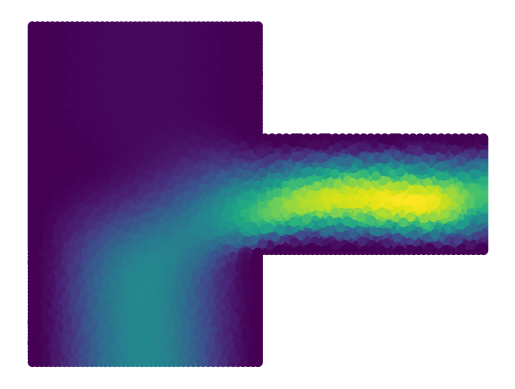

2226


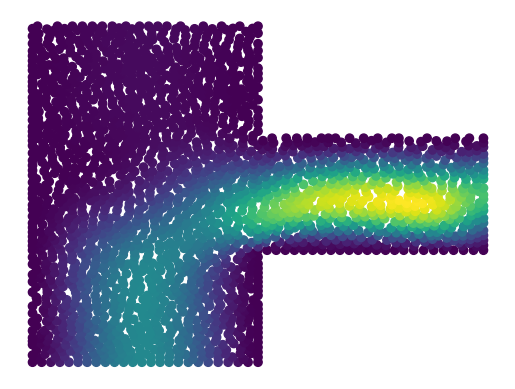

756


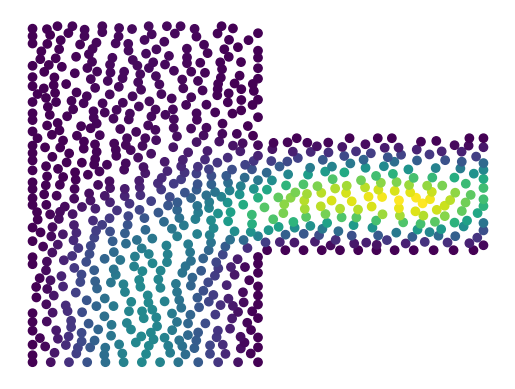

262


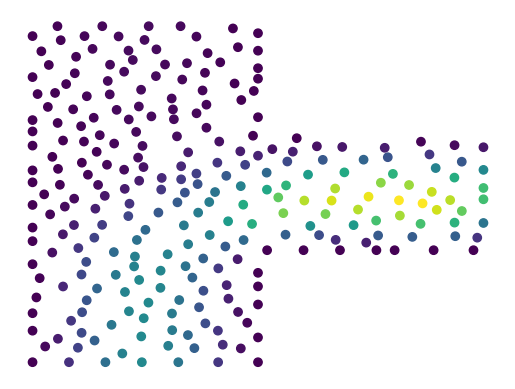

In [128]:
plt.scatter(reference_mesh[:, 0], reference_mesh[:, 1], c=(snapshot_matrix[0, :, :]**2).sum(axis=1))
plt.axis('off')
plt.show()




subsample = MFNUS(reference_mesh)
print(len(subsample))

subsampled_mesh = reference_mesh[subsample]
subsampled_solution = snapshot_matrix[:, subsample, :]

np.save('data/reference_mesh_medium.npy', subsampled_mesh)
np.save('data/snapshot_matrix_medium.npy', subsampled_solution)

plt.scatter(subsampled_mesh[:, 0], subsampled_mesh[:, 1], c=(subsampled_solution[0, :, :]**2).sum(axis=1))
plt.axis('off')
plt.show()




subsample = MFNUS(subsampled_mesh)
print(len(subsample))

subsampled_mesh = subsampled_mesh[subsample]
subsampled_solution = subsampled_solution[:, subsample, :]

np.save('data/reference_mesh_small.npy', subsampled_mesh)
np.save('data/snapshot_matrix_small.npy', subsampled_solution)

plt.scatter(subsampled_mesh[:, 0], subsampled_mesh[:, 1], c=(subsampled_solution[0, :, :]**2).sum(axis=1))
plt.axis('off')
plt.show()




subsample = MFNUS(subsampled_mesh)
print(len(subsample))

subsampled_mesh = subsampled_mesh[subsample]
subsampled_solution = subsampled_solution[:, subsample, :]

np.save('data/reference_mesh_tiny.npy', subsampled_mesh)
np.save('data/snapshot_matrix_tiny.npy', subsampled_solution)

plt.scatter(subsampled_mesh[:, 0], subsampled_mesh[:, 1], c=(subsampled_solution[0, :, :]**2).sum(axis=1))
plt.axis('off')
plt.show()